### Notebook to plot and organize CuteChess metrics form a nni experiment

In [384]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import glob
import os
import configparser
import re
from pathlib import Path
import ast
import json

In [385]:
## path to experiment directory
experiment_path = r"C:\Users\Daniel\nni-experiments\0Hjkne4l"
trials_path = experiment_path + r"\trials"

## engine names  (elo diff from contender perspective)
baseline_name = "CrazyAra_small_mobile_v2"
contender_name = "CrazyAra_RISEv2_27_blocks"

In [386]:
##dict containing all trials with key of the fixed_movetime
experiment_dict = {}

movetimes = list()
## iterate over all trials
parser = configparser.ConfigParser()
for trial in os.scandir(trials_path):
    parameter_file = open(Path(trial.path + r"\parameter.cfg"))
    metric_file = open(Path(trial.path + r"\.nni\metrics"))
    parameter = ast.literal_eval(parameter_file.read())['parameters']
    test = metric_file.read()
    metric = re.findall(r"[{][\s\S]*[}]", test)

    if metric:
        metric = metric[0]
        metric = ast.literal_eval(metric)

    ## configure dict for trial, containing metrics (elo+var) and settings
    trial_dict = {}
    trial_dict.update(parameter)
    if metric:
        trial_dict['elo'] = float(metric['value'])
        trial_dict['variance'] = float(metric['variance'])
    else:
        trial_dict['elo'] = 'inf'
        trial_dict['variance'] = 'nan'

    movetimes.append(parameter['Fixed_Movetime'])

    if parameter['Fixed_Movetime'] not in experiment_dict:
        experiment_dict[parameter['Fixed_Movetime']] = list()
    experiment_dict[parameter['Fixed_Movetime']].append(trial_dict)
## add movetimes to the dict
experiment_dict['Movetime'] = movetimes

In [387]:
print(plt.style.available)
# plt.style.use('seaborn-paper')
plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
# plt.style.use('seaborn-white')
#plt.style.use('fivethirtyeight')
rc('font', **{'family': 'serif'})  # ,'sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
# print(plt.rcParams.keys())
plt.rcParams['legend.frameon'] = 'True'
plt.rcParams['legend.framealpha'] = '1.0'
print(plt.rcParams['figure.figsize'])
plt.rcParams['figure.figsize'] = [6.4*0.7, 4.8*0.7] #(15, 5)
plt.rcParams['axes.grid.axis'] = 'y' #False
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
linestyle_str = [
  ('solid', 'solid'),  # Same as (0, ()) or '-'
  ('dotted', 'dotted'),  # Same as (0, (1, 1)) or '.'
  ('dashed', 'dashed'),  # Same as '--'
  ('dashdot', 'dashdot')]  # Same as '-.'
linestyle_tuple = [
  ('loosely dotted', (0, (1, 10))),
  ('dotted', (0, (1, 1))),
  ('densely dotted', (0, (1, 1))),

  ('loosely dashed', (0, (5, 10))),
  ('dashed', (0, (5, 5))),
  ('densely dashed', (0, (5, 1))),

  ('loosely dashdotted', (0, (3, 10, 1, 10))),
  ('dashdotted', (0, (3, 5, 1, 5))),
  ('densely dashdotted', (0, (3, 1, 1, 1))),

  ('dashdotdotted', (0, (3, 5, 1, 5, 1, 5))),
  ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
  ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
[4.4799999999999995, 3.36]


In [388]:
x = experiment_dict['Movetime']
x.sort()
elo =  list()
variance = list()

for timestamp in x:
    elo_tmp = []
    var_tmp = []
    settings = experiment_dict[timestamp]
    for plot_setting in settings:
        elo_tmp.append(float(plot_setting['elo']))
        var_tmp.append(float(plot_setting['variance']))
    elo.append(elo_tmp)
    variance.append(var_tmp)

elo = np.column_stack(elo).tolist()
variance = np.column_stack(variance).tolist()

## create Plot label
plot_label =  list()
for param in experiment_dict[x[0]]:
    str_tmp = ""
    for key in param.keys():
        if key != 'Fixed_Movetime' and key != 'elo' and key != 'variance': ## already stated
            next_arg = ""
            if isinstance(param[key],str):
                if param[key] == 'true':
                    next_arg = key
            else: ## param is float/(int)
                next_arg =  key + " = " + str(param[key])
            if next_arg:
                if not str_tmp:
                    str_tmp = next_arg
                else:
                    str_tmp = str_tmp + "; " + next_arg
    plot_label.append(str_tmp)


## add elo and var to experiment dict for better access later
plot_dict = {}
plot_dict['x'] = x
plot_dict['elo'] = elo
plot_dict['var'] = variance
plot_dict['label'] = plot_label
plot_dict['contender_name'] = contender_name
plot_dict['baseline_name'] = baseline_name

experiment_dict['plot_data'] = plot_dict

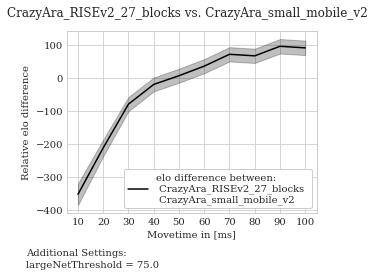

In [389]:
figures = list()
for elo_plt, var_plt, label in zip(np.array(elo), np.array(variance), np.array(plot_label)):
    fig = plt.figure()
    fig.suptitle("{} vs. {}".format(contender_name, baseline_name))
    plt.grid(True)
    fig.text(0, -0.05, "Additional Settings:")
    fig.text(0,-0.10,label)
    plt.xticks(x)
    plt.xlabel("Movetime in [ms]")
    plt.ylabel("Relative elo difference")
    plt.plot(x, elo_plt, label="elo difference between: \n {} \n {}".format(contender_name, baseline_name))
    plt.fill_between(x, elo_plt - var_plt, elo_plt + var_plt, color='black', alpha=0.25)
    plt.legend()
    plt.show()

    figures.append(fig)

In [390]:
plot_data_dir = experiment_path + r"\plot_data"
if not os.path.isdir(plot_data_dir):
    os.mkdir(plot_data_dir)

with open(plot_data_dir + r'\experiment_data.json', 'w') as file:
    json.dump(experiment_dict, file, indent=len(x))

for fig, plot_num in zip(figures,  np.arange(len(figures))):
    fig.savefig(plot_data_dir + r"\{}_vs_{}_{}".format(contender_name, baseline_name, plot_num), bbox_inches="tight")
